In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 3070 Ti


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split, Dataset
import time
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import pandas as pd
import os

In [3]:
'''import os
from PIL import Image
from torchvision import datasets
from tqdm import tqdm
import torch

# 1. Config Path
input_dir = r'food-101\food-101\images'       # โฟลเดอร์รูปเดิม (ใหญ่)
output_dir = r'food-101-resized'              # โฟลเดอร์ใหม่ (ที่จะสร้าง)
target_size = (224, 224)

# 2. ฟังก์ชันย่อรูป
def resize_and_save():
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # อ่านโครงสร้างโฟลเดอร์เดิม
    dataset = datasets.ImageFolder(input_dir)
    
    print(f"กำลังย่อรูปจำนวน {len(dataset)} รูป... (อาจใช้เวลาสักพัก)")
    
    # วนลูปทุกรูป
    for idx, (path, label) in enumerate(tqdm(dataset.samples)): # ใช้ tqdm แสดงหลอดโหลด
        # path คือที่อยู่ไฟล์เดิม ('food-101/images/sushi/123.jpg')
        
        # สร้าง path ปลายทาง โดยคงชื่อโฟลเดอร์ย่อยไว้
        # เช่น food-101-resized/sushi/123.jpg
        rel_path = os.path.relpath(path, input_dir)
        dest_path = os.path.join(output_dir, rel_path)
        dest_folder = os.path.dirname(dest_path)
        
        if not os.path.exists(dest_folder):
            os.makedirs(dest_folder)
            
        try:
            # เปิดและย่อรูป
            with Image.open(path) as img:
                img = img.convert('RGB') # แปลงเป็น RGB เผื่อเจอ Greyscale
                img_resized = img.resize(target_size, Image.Resampling.LANCZOS)
                
                # เซฟลงที่ใหม่ (ลด Quality ลงนิดหน่อยเพื่อให้อ่านไวขึ้น)
                img_resized.save(dest_path, quality=90)
        except Exception as e:
            print(f"Error processing {path}: {e}")

if __name__ == '__main__':
    resize_and_save()
    print("✅ ย่อรูปเสร็จสิ้น! กรุณาเปลี่ยน path ในโค้ดเทรนไปที่โฟลเดอร์ใหม่")'''

'import os\nfrom PIL import Image\nfrom torchvision import datasets\nfrom tqdm import tqdm\nimport torch\n\n# 1. Config Path\ninput_dir = r\'food-101\x0cood-101\\images\'       # โฟลเดอร์รูปเดิม (ใหญ่)\noutput_dir = r\'food-101-resized\'              # โฟลเดอร์ใหม่ (ที่จะสร้าง)\ntarget_size = (224, 224)\n\n# 2. ฟังก์ชันย่อรูป\ndef resize_and_save():\n    if not os.path.exists(output_dir):\n        os.makedirs(output_dir)\n\n    # อ่านโครงสร้างโฟลเดอร์เดิม\n    dataset = datasets.ImageFolder(input_dir)\n    \n    print(f"กำลังย่อรูปจำนวน {len(dataset)} รูป... (อาจใช้เวลาสักพัก)")\n    \n    # วนลูปทุกรูป\n    for idx, (path, label) in enumerate(tqdm(dataset.samples)): # ใช้ tqdm แสดงหลอดโหลด\n        # path คือที่อยู่ไฟล์เดิม (\'food-101/images/sushi/123.jpg\')\n        \n        # สร้าง path ปลายทาง โดยคงชื่อโฟลเดอร์ย่อยไว้\n        # เช่น food-101-resized/sushi/123.jpg\n        rel_path = os.path.relpath(path, input_dir)\n        dest_path = os.path.join(output_dir, rel_path)\n       

Configuration & Setup

In [4]:
data_dir = r'food-101-resized' 

BATCH_SIZE = 128        # ถ้า GPU Memory เต็ม ให้ลดเหลือ 16 หรือ 8
NUM_EPOCHS = 20        # จำนวนรอบสูงสุด (มี Early Stopping ช่วยหยุดก่อนได้)
LEARNING_RATE = 0.001
PATIENCE = 5           # ถ้านิ่ง 5 รอบให้หยุด (Early Stopping)

# ตรวจสอบ GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔹 Using device: {device}")

🔹 Using device: cuda


Custom Dataset Class

In [5]:
class MapDataset(Dataset):
    """
    Class นี้ช่วยให้เรา map transform ที่แตกต่างกันให้กับ
    subset ที่ถูกแบ่งมาจาก dataset ก้อนเดียวกัน
    """
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.dataset)

Data Transforms (Augmentation)

In [6]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(p = 0.5),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Val/Test: ห้ามปรุงแต่งภาพ แค่ปรับขนาด
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
import io
from PIL import Image
from tqdm import tqdm # ใช้แสดงหลอดโหลด

# ==========================================
# 1. เพิ่ม Class นี้ลงไป (แทนที่ Dataset เดิม)
# ==========================================
class InMemoryJPEGDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.samples = []
        
        # ใช้ ImageFolder เพื่อช่วยสแกนหา Path รูปและชื่อ Class
        print(f"🔍 Scanning files in {root_dir}...")
        temp_dataset = datasets.ImageFolder(root_dir)
        self.classes = temp_dataset.classes
        
        print(f"🚀 Loading {len(temp_dataset)} images into RAM (32GB is plenty!)...")
        
        # วนลูปอ่านไฟล์ทีละรูป เก็บเป็น Byte (ประหยัดแรมกว่าเก็บเป็นภาพ)
        for path, label in tqdm(temp_dataset.samples):
            with open(path, 'rb') as f:
                img_bytes = f.read() # อ่านเป็นก้อนข้อมูลดิบ
                self.samples.append((img_bytes, label))
                
        print("✅ All images loaded to RAM! Disk I/O is now eliminated.")

    def __getitem__(self, index):
        img_bytes, label = self.samples[index]
        
        # แปลง Bytes กลับเป็นรูปภาพตอนจะใช้เท่านั้น (On-the-fly)
        img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
            
        return img, label

    def __len__(self):
        return len(self.samples)

Load & Split Data

In [8]:
def prepare_data(data_dir):
    print("\n🔹 Loading Data to RAM...")
    
    # *** เรียกใช้ Class ใหม่ที่สร้างไว้ ***
    full_dataset_ram = InMemoryJPEGDataset(data_dir) 
    
    class_names = full_dataset_ram.classes
    num_classes = len(class_names)
    
    # แบ่ง Train/Val/Test (Logic เดิม)
    total_len = len(full_dataset_ram)
    train_len = int(0.8 * total_len)
    val_len = int(0.1 * total_len)
    test_len = total_len - train_len - val_len

    # ใช้ dataset ก้อนใหญ่ใน RAM มาแบ่ง
    train_subset, val_subset, test_subset = random_split(
        full_dataset_ram, [train_len, val_len, test_len],
        generator=torch.Generator().manual_seed(42)
    )

    # Wrap ด้วย MapDataset เพื่อใส่ Transform (ใช้ Class MapDataset เดิมที่คุณมี)
    train_dataset = MapDataset(train_subset, train_transforms)
    val_dataset = MapDataset(val_subset, val_transforms)
    test_dataset = MapDataset(test_subset, val_transforms)

    # DataLoader
    # หมายเหตุ: เมื่อข้อมูลอยู่ใน RAM แล้ว num_workers=0 จะเร็วมากและเสถียรสุดบน Windows
    # แต่ถ้าอยากลองเร่ง สามารถลองเปลี่ยนเป็น 2 ได้ (แต่ 0 ก็เร็วเหลือเฟือแล้วครับกรณีนี้)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    print(f"   Split: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")
    return train_loader, val_loader, test_loader, class_names, num_classes

Model Setup (VGG16 Transfer Learning)

In [9]:
def build_model(num_classes):
    print("\n🔹 Building VGG16 Model...")
    # โหลด Pre-trained Weights
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

    # Freeze Feature Layers (ส่วนสมอง)
    for param in model.features.parameters():
        param.requires_grad = False

    # แก้ไข Classifier Layer สุดท้าย
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, num_classes)

    model = model.to(device)
    return model

Training Function (Advanced)

In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience):
    start = time.time()
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    patience_counter = 0 
    
    # Scheduler: ลด LR ลงถ้า Loss ไม่ลดลง 3 รอบ
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    print("\n🔹 Start Training...")
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Record history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                
                # Update Scheduler & Check Early Stopping
                scheduler.step(epoch_loss)

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), 'best_model_food101.pth') # Save ทันทีที่ดีที่สุด
                    print(f"   --> 💾 Saved new best model (Acc: {best_acc:.4f})")
                    patience_counter = 0
                else:
                    patience_counter += 1
        
        if patience_counter >= patience:
            print(f"\n⏹ Early Stopping triggered at epoch {epoch+1}!")
            break

    time_elapsed = time.time() - start
    print(f'\n✅ Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_acc:4f}')

    # Load best weights before returning
    model.load_state_dict(best_model_wts)
    return model, history

Evaluation & Visualization

In [11]:
def evaluate_and_plot(model, history, test_loader, class_names):
    print("\n🔹 Starting Evaluation...")
    
    # 1. Plot Training History
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Acc')
    plt.plot(epochs_range, val_acc, label='Validation Acc')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    # 2. Test Set Evaluation
    print("   Generating predictions on Test Set...")
    y_pred = []
    y_true = []
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    # 3. F1 Score
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"\n📊 Weighted F1-Score: {f1:.4f}")
    
    # 4. Classification Report (แสดงแค่ 10 คลาสแรกถ้ามันยาวเกิน)
    print("\n📊 Classification Report (First 10 classes):")
    print(classification_report(y_true, y_pred, target_names=class_names, labels=range(10), digits=4))

    # 5. Confusion Matrix
    print("\n📊 Plotting Confusion Matrix...")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(24, 24)) # ขนาดใหญ่พิเศษสำหรับ 101 คลาส
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix: Food-101')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()


🔹 Loading Data to RAM...
🔍 Scanning files in food-101-resized...
🚀 Loading 101000 images into RAM (32GB is plenty!)...


100%|██████████| 101000/101000 [07:02<00:00, 239.18it/s]


✅ All images loaded to RAM! Disk I/O is now eliminated.
   Split: Train=80800, Val=10100, Test=10100

🔹 Building VGG16 Model...


d:\anaconda3\envs\dlenv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



🔹 Start Training...

Epoch 1/20
----------
Train Loss: 2.7949 Acc: 0.3332
Val Loss: 1.9863 Acc: 0.5036
   --> 💾 Saved new best model (Acc: 0.5036)

Epoch 2/20
----------
Train Loss: 2.0793 Acc: 0.4671
Val Loss: 1.8254 Acc: 0.5334
   --> 💾 Saved new best model (Acc: 0.5334)

Epoch 3/20
----------
Train Loss: 1.8941 Acc: 0.5087
Val Loss: 1.7323 Acc: 0.5529
   --> 💾 Saved new best model (Acc: 0.5529)

Epoch 4/20
----------
Train Loss: 1.7652 Acc: 0.5378
Val Loss: 1.6766 Acc: 0.5659
   --> 💾 Saved new best model (Acc: 0.5659)

Epoch 5/20
----------
Train Loss: 1.6619 Acc: 0.5611
Val Loss: 1.6263 Acc: 0.5758
   --> 💾 Saved new best model (Acc: 0.5758)

Epoch 6/20
----------
Train Loss: 1.5784 Acc: 0.5800
Val Loss: 1.5985 Acc: 0.5831
   --> 💾 Saved new best model (Acc: 0.5831)

Epoch 7/20
----------
Train Loss: 1.4993 Acc: 0.5979
Val Loss: 1.5708 Acc: 0.5937
   --> 💾 Saved new best model (Acc: 0.5937)

Epoch 8/20
----------
Train Loss: 1.4261 Acc: 0.6156
Val Loss: 1.5523 Acc: 0.5962
   --> 

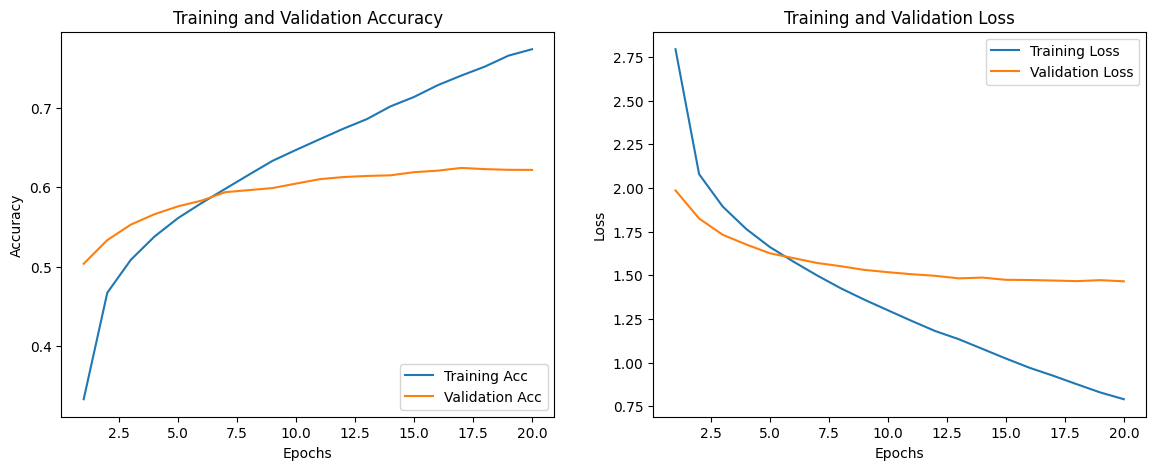

   Generating predictions on Test Set...

📊 Weighted F1-Score: 0.6151

📊 Classification Report (First 10 classes):
                         precision    recall  f1-score   support

              apple_pie     0.4348    0.3306    0.3756       121
         baby_back_ribs     0.5827    0.7048    0.6379       105
                baklava     0.6017    0.6827    0.6396       104
         beef_carpaccio     0.6441    0.6387    0.6414       119
           beef_tartare     0.5056    0.4167    0.4569       108
             beet_salad     0.4505    0.4762    0.4630       105
               beignets     0.7636    0.7925    0.7778       106
               bibimbap     0.7699    0.7982    0.7838       109
          bread_pudding     0.3465    0.3697    0.3577       119
      breakfast_burrito     0.5275    0.4800    0.5026       100

              micro avg     0.5648    0.5648    0.5648      1096
              macro avg     0.5627    0.5690    0.5636      1096
           weighted avg     0.5600    

d:\anaconda3\envs\dlenv\lib\site-packages\sklearn\metrics\_classification.py:2964: UserWarning: labels size, 10, does not match size of target_names, 101
  warnings.warn(


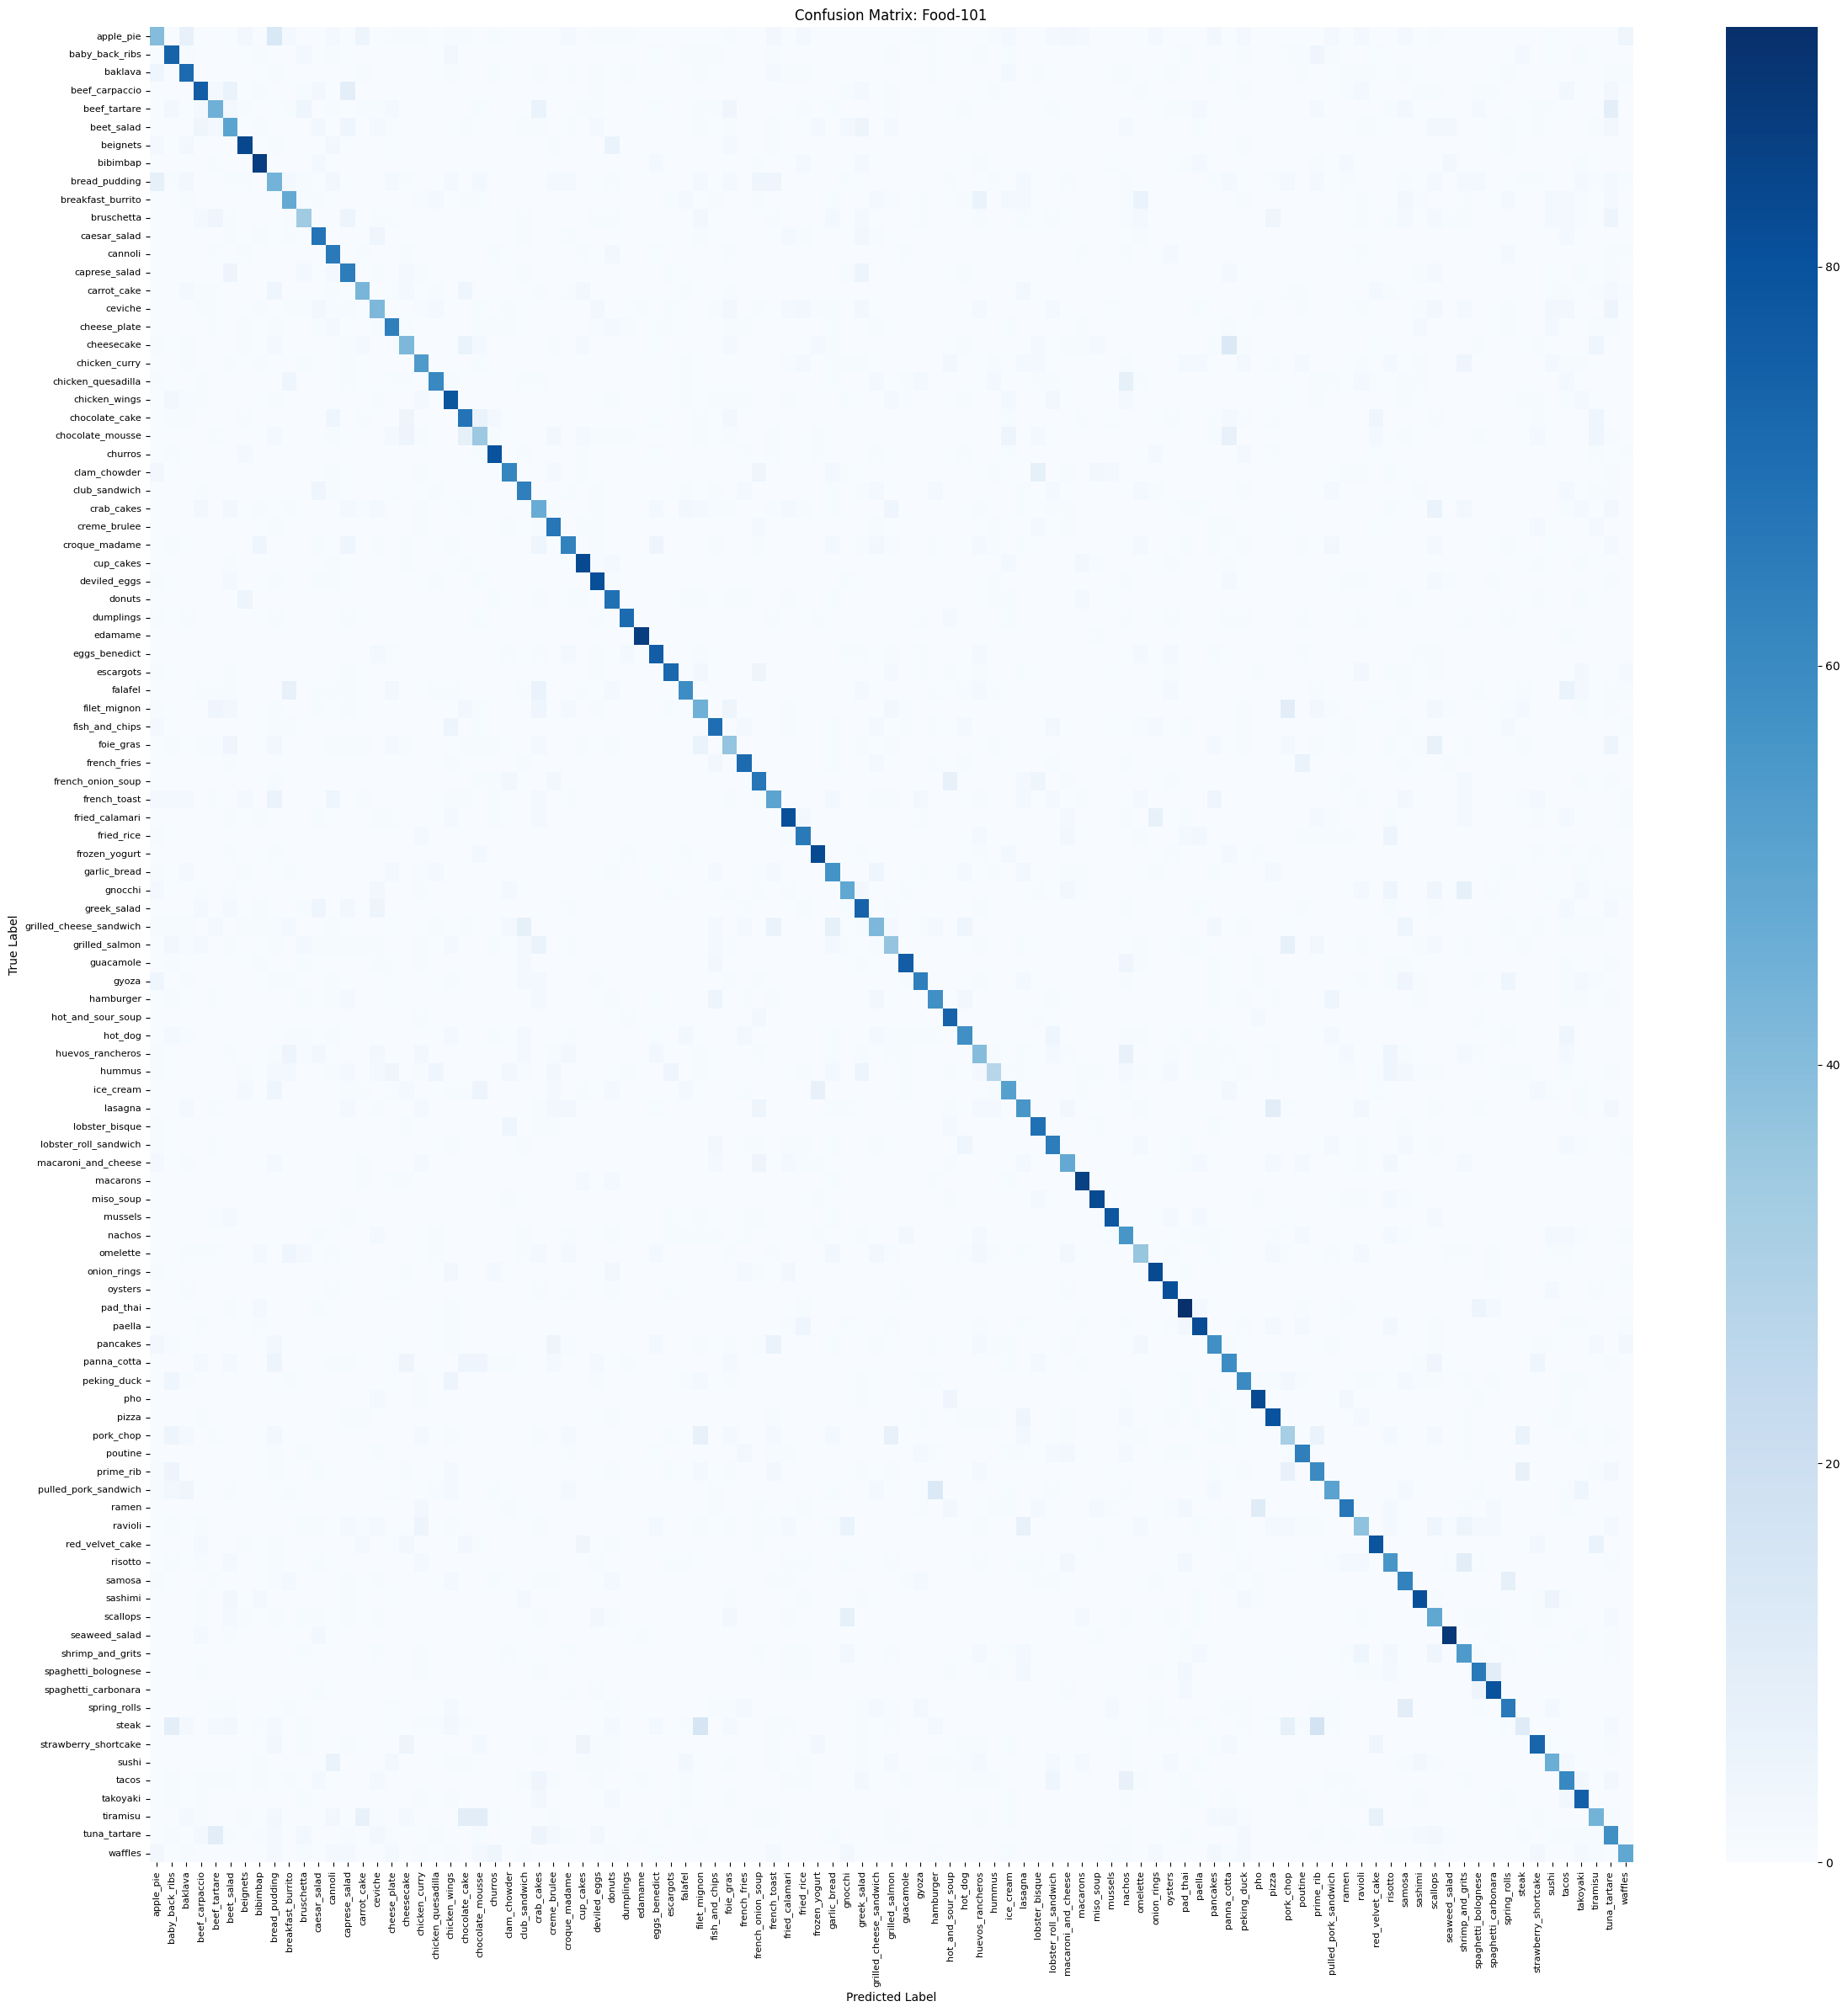


✅ All processes finished successfully!


In [12]:
if __name__ == '__main__':
    # 1. Prepare Data
    train_loader, val_loader, test_loader, class_names, num_classes = prepare_data(data_dir)
    
    # 2. Build Model
    model = build_model(num_classes)
    
    # 3. Setup Loss & Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.classifier.parameters(), lr=LEARNING_RATE, momentum=0.9)
    
    # 4. Train
    trained_model, history = train_model(
        model, 
        train_loader, 
        val_loader, 
        criterion, 
        optimizer, 
        num_epochs=NUM_EPOCHS, 
        patience=PATIENCE
    )
    
    # 5. Evaluate
    evaluate_and_plot(trained_model, history, test_loader, class_names)
    
    print("\n✅ All processes finished successfully!")

In [ ]:
train_loader, val_loader, test_loader, class_names, num_classes = prepare_data(data_dir)

In [ ]:
model = build_model(num_classes)


🔹 Building VGG16 Model...


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=LEARNING_RATE, momentum=0.9)

In [ ]:
trained_model, history = train_model(
        model, 
        train_loader, 
        val_loader, 
        criterion, 
        optimizer, 
        num_epochs=NUM_EPOCHS, 
        patience=PATIENCE
    )

d:\anaconda3\envs\dlenv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



🔹 Start Training...

Epoch 1/20
----------
